In [45]:
import itertools
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from time import time

In [46]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [47]:
# load dataset
dataset = read_csv('energy_weather_global_data.csv', header=0, index_col=0)
dataset.index.name = 'datetime'
values = dataset.values
dataset.head()

,windSpeed,humidity,temp,demand,hour,dayofweek,month,temp_lag1,temp_lag2,temp_lag3,...,humidity_lag3,humidity_lag4,humidity_lag5,humidity_lag6,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.3963,0.7792,0.3523,0.4844,0.0000,0.3333,0.0,0.3436,0.3202,0.3039,...,0.7532,0.7532,0.7792,0.7532,0.4860,0.5510,0.6130,0.6836,0.7551,0.7676
2014-01-01 01:00:00,0.3618,0.7662,0.3297,0.4184,0.0435,0.3333,0.0,0.3523,0.3436,0.3202,...,0.8312,0.7532,0.7532,0.7792,0.4845,0.4864,0.5510,0.6130,0.6836,0.7551
2014-01-01 02:00:00,0.3591,0.8571,0.3215,0.3422,0.0870,0.3333,0.0,0.3297,0.3523,0.3436,...,0.8312,0.8312,0.7532,0.7532,0.4185,0.4849,0.4864,0.5510,0.6130,0.6836
2014-01-01 03:00:00,0.2730,0.8312,0.3260,0.2848,0.1304,0.3333,0.0,0.3215,0.3297,0.3523,...,0.7792,0.8312,0.8312,0.7532,0.3423,0.4190,0.4849,0.4864,0.5510,0.6130
2014-01-01 04:00:00,0.2967,0.8571,0.3254,0.2533,0.1739,0.3333,0.0,0.3260,0.3215,0.3297,...,0.7662,0.7792,0.8312,0.8312,0.2849,0.3428,0.4190,0.4849,0.4864,0.5510


In [ ]:
# integer encode direction
encoder = LabelEncoder()
[encoder.fit_transform(values[:,categor_variable]) for categor_variable in range(4,7)]
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,11,12,13]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
autocorrelation_plot(dataset['energy'].dropna())
pyplot.xlim(0,24)
pyplot.title('Auto-correlation of hourly demand over a 24 hour period')
pyplot.show()

In [48]:
reframed.columns = ['windSpeed', 'humidity' ,'temperature' ,'energy_1', 'hour' ,'dayofweek', 'month', 'energy']
reframed.head()

,windSpeed,humidity,temp,demand,hour,dayofweek,month,temp_lag1,temp_lag2,temp_lag3,...,humidity_lag3,humidity_lag4,humidity_lag5,humidity_lag6,demand_lag1,demand_lag2,demand_lag3,demand_lag4,demand_lag5,demand_lag6
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.3963,0.7792,0.3523,0.4844,0.0000,0.3333,0.0,0.3436,0.3202,0.3039,...,0.7532,0.7532,0.7792,0.7532,0.4860,0.5510,0.6130,0.6836,0.7551,0.7676
2014-01-01 01:00:00,0.3618,0.7662,0.3297,0.4184,0.0435,0.3333,0.0,0.3523,0.3436,0.3202,...,0.8312,0.7532,0.7532,0.7792,0.4845,0.4864,0.5510,0.6130,0.6836,0.7551
2014-01-01 02:00:00,0.3591,0.8571,0.3215,0.3422,0.0870,0.3333,0.0,0.3297,0.3523,0.3436,...,0.8312,0.8312,0.7532,0.7532,0.4185,0.4849,0.4864,0.5510,0.6130,0.6836
2014-01-01 03:00:00,0.2730,0.8312,0.3260,0.2848,0.1304,0.3333,0.0,0.3215,0.3297,0.3523,...,0.7792,0.8312,0.8312,0.7532,0.3423,0.4190,0.4849,0.4864,0.5510,0.6130
2014-01-01 04:00:00,0.2967,0.8571,0.3254,0.2533,0.1739,0.3333,0.0,0.3260,0.3215,0.3297,...,0.7662,0.7792,0.8312,0.8312,0.2849,0.3428,0.4190,0.4849,0.4864,0.5510


In [ ]:
# LSTM Network

optimizers_list = ['adam','sgd','Adagrad','RMSprop','Adadelta','Adamax','Nadam']
loss_list = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','mean_squared_logarithmic_error','squared_hinge','hinge','categorical_hinge','logcosh']
for optim, loss_func in itertools.product(optimizers_list, loss_list):
    # split into train and test sets
    values = reframed.values
    n_train_hours = 500 * 24
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # Only for LSTM
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # LSTM Network
    # design network
    LSTM_start_time = time()
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss=loss_func, optimizer=optim)
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=False, shuffle=False)
    """
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    """
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    LSTM_total_time = time() - LSTM_start_time
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    r2_error = r2_score(inv_y, inv_yhat)
    print("Parameters: {}, {} | Test RMSE: {:0.3f} | Test R2: {:0.3f} | Model Time: {:0.3f}".format(optim, loss_func, rmse, r2_error, LSTM_total_time))
    ###############!!LSTM END!!#####################
#Plot Reality vs prediction
equality = inv_yhat - inv_y
pyplot.plot(equality)
pyplot.show()

In [51]:
#######################
# RUN BEFORE ALL MODELS
#######################
X = reframed.values[:,0:7]
Y = reframed.values[:,7]
tscv = TimeSeriesSplit(n_splits=2)
print(tscv)
#######################
#######################
#######################
#######################
#######################
#######################

TimeSeriesSplit(max_train_size=None, n_splits=5)


1393

In [54]:
# Random Forest With CrossValidation
rfbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Random Forest Model
    from sklearn.ensemble import RandomForestRegressor
    import numpy
    n_trees = [500]#[10,100,500]
    max_features_input = ['auto'] #['auto','sqrt','log2']
    max_depth_in = [14] #range(2,15)
    rmse_ref = numpy.inf
    best_model={}
    for trees, feat_in, max_d_in in itertools.product(n_trees, max_features_input, max_depth_in):    
        #Random Forest Model
        RF_start_time = time()
        RFmodel= RandomForestRegressor(n_estimators=trees ,max_features=feat_in ,max_depth=max_d_in, random_state=0)
        RFmodel.fit(X_train, y_train)
    
        y_pred=RFmodel.predict(X_test)
    
    
        RF_total_time = time() - RF_start_time
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2_error = r2_score(y_test, y_pred)
        if rmse < rmse_ref:
            rmse_ref = rmse
            best_model = "Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(trees, feat_in, max_d_in, rmse, r2_error, RF_total_time)
        #print("Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(trees, feat_in, max_d_in, rmse, r2_error, RF_total_time))
    rfbestmodel['rmse'].append(rmse)
    rfbestmodel['r2'].append(r2_error)
    rfbestmodel['time'].append(RF_total_time)
    print(best_model)
        ###############!!RF END!!#####################

Parameters: 500 auto 14 | RMSE: 0.024 | R2: 0.977 | Model Time: 65.098


In [55]:
# ARIMA With CrossValidation
arbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
X_train, X_test = X[train_index], X[test_index]
    train, test = Y[train_index], Y[test_index]
    
    from statsmodels.tsa.arima_model import ARIMA
    import numpy
    history = [x for x in train]
    order_pairs = [(1,0,0),(2,0,0),(3,0,1),(3,0,0),(3,0,2)]
    rmse_ref=numpy.inf
    for pairs in order_pairs:
        predictions = list()
        tic = time()
        model = ARIMA(history, order=pairs, freq='H')
        model_fit = model.fit(disp=0)
        toc=time()-tic
        for t in range(len(test)):
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
    
        rmse = sqrt(mean_squared_error(test, predictions))
        r2_arima=r2_score(test, predictions)
        if rmse<rmse_ref:
            rmse_ref=rmse
            best_model="Parameters: {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(pairs, rmse, r2_arima ,toc)
        print("Parameters: {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(pairs, rmse, r2_arima ,toc))
    arbestmodel['rmse'].append(rmse)
    arbestmodel['r2'].append(r2_arima)
    arbestmodel['time'].append(toc)
    print(best_model)
###############!!ARIMA END!!#####################

Parameters: (1, 0, 0) | RMSE: 0.301 | R2: -2.556 | Model Time: 0.101
Parameters: (2, 0, 0) | RMSE: 0.162 | R2: -0.034 | Model Time: 0.950
Parameters: (3, 0, 1) | RMSE: 0.161 | R2: -0.024 | Model Time: 6.668
Parameters: (3, 0, 0) | RMSE: 0.162 | R2: -0.033 | Model Time: 2.085
Parameters: (3, 0, 2) | RMSE: 0.162 | R2: -0.029 | Model Time: 12.723
Parameters: (3, 0, 1) | RMSE: 0.161 | R2: -0.024 | Model Time: 6.668


In [32]:
# Seasonal ARIMA With CrossValidation
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
arbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    train, test = Y[train_index], Y[test_index]
    
    from statsmodels.tsa.arima_model import ARIMA
    import numpy
    history = [x for x in train]
    order_pairs = [(2,0,1)]#[(1,0,0),(2,0,0),(3,1,0),(4,0,0),(6,1,0),(3,2,0),(1,1,1),(2,1,1),(3,1,1),(4,1,1),(6,1,1),(3,2,1)]
    rmse_ref=numpy.inf
    for pairs in order_pairs:
        predictions = list()
        tic = time()
        
        model = sm.tsa.statespace.SARIMAX(history,
                                order=pairs,
                                seasonal_order=(1, 0, 0, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

        model_fit = model.fit()

        #print(results.summary().tables[1])

        #model = ARIMA(history, order=pairs, freq='H')
        #model_fit = model.fit(disp=0)
        toc=time()-tic
        for t in range(len(test)):
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
    
        rmse = sqrt(mean_squared_error(test, predictions))
        r2_error=r2_score(test, predictions)
        if rmse<rmse_ref:
            rmse_ref=rmse
            best_model="Parameters: {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(pairs, rmse, r2_error ,toc)
        #print("Parameters: {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(pairs, rmse, r2_error ,toc))
    arbestmodel['rmse'].append(rmse)
    arbestmodel['r2'].append(r2_error)
    arbestmodel['time'].append(toc)
    print(best_model)
###############!!Seasonal ARIMA END!!#####################

Parameters: (2, 0, 1) | RMSE: 0.171 | R2: -0.171 | Model Time: 2.950
Parameters: (2, 0, 1) | RMSE: 0.171 | R2: -0.171 | Model Time: 2.950
Parameters: (2, 0, 1) | RMSE: 0.229 | R2: -3.746 | Model Time: 4.633
Parameters: (2, 0, 1) | RMSE: 0.229 | R2: -3.746 | Model Time: 4.633
Parameters: (2, 0, 1) | RMSE: 0.088 | R2: -0.076 | Model Time: 8.324
Parameters: (2, 0, 1) | RMSE: 0.088 | R2: -0.076 | Model Time: 8.324
Parameters: (2, 0, 1) | RMSE: 0.129 | R2: -0.018 | Model Time: 9.823
Parameters: (2, 0, 1) | RMSE: 0.129 | R2: -0.018 | Model Time: 9.823
Parameters: (2, 0, 1) | RMSE: 0.299 | R2: -2.515 | Model Time: 11.594
Parameters: (2, 0, 1) | RMSE: 0.299 | R2: -2.515 | Model Time: 11.594


In [56]:
# Linear Regression With CrossValidation
lsbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    from sklearn.linear_model import LinearRegression
    import numpy
    parameter = [True] #[True, False]
    rmse_ref = numpy.inf
    best_model={}
    for param in parameter:    
        #Random Forest Model
        LR_start_time = time()
        linreg=LinearRegression(normalize=param, n_jobs=-1)
        linreg.fit(X_train, y_train)
        y_pred=linreg.predict(X_test)
        
        LR_total_time = time() - LR_start_time
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2_error = r2_score(y_test, y_pred)
        if rmse < rmse_ref:
            rmse_ref = rmse
            best_model = "Parameters: {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(param, rmse, r2_error, LR_total_time)
        #print("Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(trees, feat_in, max_d_in, rmse, r2_error, RF_total_time))
    lsbestmodel['rmse'].append(rmse)
    lsbestmodel['r2'].append(r2_error)
    lsbestmodel['time'].append(LR_total_time)
    print(best_model)
        ###############!!LR END!!#####################


Parameters: True | RMSE: 0.036 | R2: 0.946 | Model Time: 0.010


In [57]:
# Decision Tree With CrossValidation
dtbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Decision Tree Model
    from sklearn.tree import DecisionTreeRegressor
    import numpy
    criterions = ['mae'] #['mse', 'friedman_mse', 'mae']
    max_features_input = ['auto'] #['auto','sqrt','log2']
    max_depth_in = [11] #range(2,15)
    rmse_ref = numpy.inf
    best_model={}
    for crit, feat_in, max_d_in in itertools.product(criterions, max_features_input, max_depth_in):    
        #Dicision Tree Model
        DT_start_time = time()
        DTmodel= DecisionTreeRegressor(criterion=crit, max_depth=max_d_in, max_features=feat_in, random_state=0)
        DTmodel.fit(X_train, y_train)
    
        y_pred=DTmodel.predict(X_test)
    
    
        DT_total_time = time() - DT_start_time
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2_error = r2_score(y_test, y_pred)
        if rmse < rmse_ref:
            rmse_ref = rmse
            best_model = "Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(crit, feat_in, max_d_in, rmse, r2_error, DT_total_time)
        #print("Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(trees, feat_in, max_d_in, rmse, r2_error, RF_total_time))
    dtbestmodel['rmse'].append(rmse)
    dtbestmodel['r2'].append(r2_error)
    dtbestmodel['time'].append(DT_total_time)
    print(best_model)
        ###############!!DT END!!#####################

Parameters: mae auto 11 | RMSE: 0.036 | R2: 0.947 | Model Time: 8.920


In [18]:
# KNN With CrossValidation
knnbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # KNN Model
    from sklearn.neighbors import KNeighborsRegressor
    import numpy
    criterions = [10] #[1,3,5,10,20,50,100]
    max_features_input = ['auto'] #['auto','ball_tree','kd_tree','brute']
    max_depth_in = ['distance'] #['uniform','distance']
    rmse_ref = numpy.inf
    best_model={}
    for crit, feat_in, max_d_in in itertools.product(criterions, max_features_input, max_depth_in):    
        #KNN Model
        KNN_start_time = time()
        KNNmodel= KNeighborsRegressor(n_neighbors=crit, weights=max_d_in, algorithm=feat_in)
        KNNmodel.fit(X_train, y_train)
    
        y_pred=KNNmodel.predict(X_test)
    
    
        KNN_total_time = time() - KNN_start_time
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2_error = r2_score(y_test, y_pred)
        if rmse < rmse_ref:
            rmse_ref = rmse
            best_model = "Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(crit, feat_in, max_d_in, rmse, r2_error, KNN_total_time)
        #print("Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(trees, feat_in, max_d_in, rmse, r2_error, RF_total_time))
    knnbestmodel['rmse'].append(rmse)
    knnbestmodel['r2'].append(r2_error)
    knnbestmodel['time'].append(KNN_total_time)
    print(best_model)
        ###############!!KNN END!!#####################

Parameters: 10 auto distance | RMSE: 0.113 | R2: 0.486 | Model Time: 0.081
Parameters: 10 auto distance | RMSE: 0.065 | R2: 0.613 | Model Time: 0.138
Parameters: 10 auto distance | RMSE: 0.040 | R2: 0.778 | Model Time: 0.145
Parameters: 10 auto distance | RMSE: 0.075 | R2: 0.659 | Model Time: 0.203
Parameters: 10 auto distance | RMSE: 0.102 | R2: 0.592 | Model Time: 0.257


In [ ]:
# KNN Radius With CrossValidation
knnrbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # KNN Radius Model
    from sklearn.neighbors import RadiusNeighborsRegressor
    import numpy
    criterions = [1] #[1,3,5,10,20,50,100,500]
    max_features_input = ['brute'] #['auto','ball_tree','kd_tree','brute']
    max_depth_in = ['distance'] #['uniform','distance']
    rmse_ref = numpy.inf
    best_model={}
    for crit, feat_in, max_d_in in itertools.product(criterions, max_features_input, max_depth_in):    
        #KNN Radius Model
        KNNR_start_time = time()
        KNNmodel= RadiusNeighborsRegressor(radius=crit, weights=max_d_in, algorithm=feat_in)
        KNNmodel.fit(X_train, y_train)
    
        y_pred=KNNmodel.predict(X_test)
    
    
        KNNR_total_time = time() - KNNR_start_time
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2_error = r2_score(y_test, y_pred)
        if rmse < rmse_ref:
            rmse_ref = rmse
            best_model = "Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(crit, feat_in, max_d_in, rmse, r2_error, KNNR_total_time)
        #print("Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(trees, feat_in, max_d_in, rmse, r2_error, RF_total_time))
    knnrbestmodel['rmse'].append(rmse)
    knnrbestmodel['r2'].append(r2_error)
    knnrbestmodel['time'].append(KNNR_total_time)
    print(best_model)
        ###############!!KNN Radius END!!#####################

In [58]:
# SVR With CrossValidation
svrbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # SVR Model
    from sklearn.svm import SVR
    import numpy
    criterions = ['rbf'] #['poly','rbf','sigmoid']
    max_features_input = [7] #[0.1,0.7,1.5]
    max_depth_in = [0.072] #[0.8,1,2]
    rmse_ref = numpy.inf
    best_model={}
    for crit, feat_in, max_d_in in itertools.product(criterions, max_features_input, max_depth_in):    
        #SVR Model
        SVR_start_time = time()
        SVRmodel= SVR(kernel=crit, gamma=max_d_in, C=feat_in)
        SVRmodel.fit(X_train, y_train)
    
        y_pred=SVRmodel.predict(X_test)
    
    
        SVR_total_time = time() - SVR_start_time
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2_error = r2_score(y_test, y_pred)
        if rmse < rmse_ref:
            rmse_ref = rmse
            best_model = "Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(crit, feat_in, max_d_in, rmse, r2_error, SVR_total_time)
        #print("Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(crit, feat_in, max_d_in, rmse, r2_error, SVR_total_time))
    svrbestmodel['rmse'].append(rmse)
    svrbestmodel['r2'].append(r2_error)
    svrbestmodel['time'].append(SVR_total_time)
    print(best_model)
        ###############!!SVR END!!#####################

Parameters: rbf 7 0.072 | RMSE: 0.062 | R2: 0.840 | Model Time: 0.254


In [59]:
# MLPR With CrossValidation
mlprbestmodel={'rmse':[],'r2':[],'time':[]}
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # MLPR Model
    from sklearn.neural_network import MLPRegressor
    import numpy
    criterions = ['relu'] #['identity','logistic','tanh','relu']
    max_features_input = [(24,7,52)] #[(24,24),(3,3,3,3,3,3,3),(6,6,6,6),(24,7,52),(24,7,12)]
    max_depth_in = ['lbfgs'] #['lbfgs','sgd','adam']
    rmse_ref = numpy.inf
    best_model={}
    for crit, feat_in, max_d_in in itertools.product(criterions, max_features_input, max_depth_in):    
        #MLPR Model
        MLPR_start_time = time()
        MLPRmodel= MLPRegressor(activation=crit, solver=max_d_in, hidden_layer_sizes=feat_in, max_iter=200, alpha=0.01)
        MLPRmodel.fit(X_train, y_train)
    
        y_pred=MLPRmodel.predict(X_test)
    
    
        MLPR_total_time = time() - MLPR_start_time
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2_error = r2_score(y_test, y_pred)
        if rmse < rmse_ref:
            rmse_ref = rmse
            best_model = "Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(crit, feat_in, max_d_in, rmse, r2_error, MLPR_total_time)
        #print("Parameters: {} {} {} | RMSE: {:0.3f} | R2: {:0.3f} | Model Time: {:0.3f}".format(trees, feat_in, max_d_in, rmse, r2_error, RF_total_time))
    mlprbestmodel['rmse'].append(rmse)
    mlprbestmodel['r2'].append(r2_error)
    mlprbestmodel['time'].append(MLPR_total_time)
    print(best_model)
        ###############!!MLPR END!!#####################

Parameters: relu (24, 7, 52) lbfgs | RMSE: 0.033 | R2: 0.954 | Model Time: 2.672


In [ ]:
# Comparing Models
import pandas
rmse_compare = pandas.DataFrame(columns=['RF','LR','DT','KNN', 'KNNR','SVR','MLPR','ARIMA'], index=[1,2,3,4,5])
rmse_compare.RF=rfbestmodel['rmse']
rmse_compare.LR=lsbestmodel['rmse']
rmse_compare.DT=dtbestmodel['rmse']
rmse_compare.KNN=knnbestmodel['rmse']
rmse_compare.KNNR=knnrbestmodel['rmse']
rmse_compare.SVR=svrbestmodel['rmse']
rmse_compare.MLPR=mlprbestmodel['rmse']
rmse_compare.ARIMA=arbestmodel['rmse']

rmse_compare.drop(columns=['KNN','KNNR'], inplace=True)

ax = rmse_compare.plot(subplots=False, title='RMSE of Studied Models over #train samples',xticks=[1,2,3,4,5])
ax.set_xlabel("#Folds used for training")
ax.set_ylabel("RMSE")

Text(0,0.5,'R-Squared')

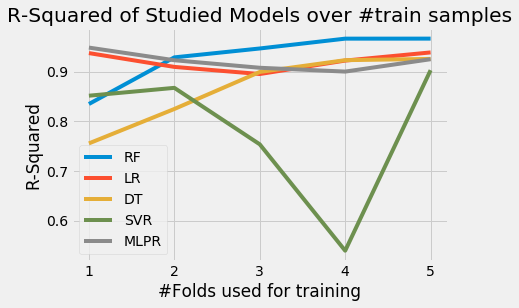

In [40]:
# Comparing Models
import pandas
r2_compare = pandas.DataFrame(columns=['RF','LR','DT','KNN', 'KNNR','SVR','MLPR'], index=[1,2,3,4,5])
r2_compare.RF=rfbestmodel['r2']
r2_compare.LR=lsbestmodel['r2']
r2_compare.DT=dtbestmodel['r2']
r2_compare.KNN=knnbestmodel['r2']
r2_compare.KNNR=knnrbestmodel['r2']
r2_compare.SVR=svrbestmodel['r2']
r2_compare.MLPR=mlprbestmodel['r2']

r2_compare.drop(columns=['KNN','KNNR'], inplace=True)

ax = r2_compare.plot(subplots=False, title='R-Squared of Studied Models over #train samples',xticks=[1,2,3,4,5])
ax.set_xlabel("#Folds used for training")
ax.set_ylabel("R-Squared")

Text(0,0.5,'Execution Time')

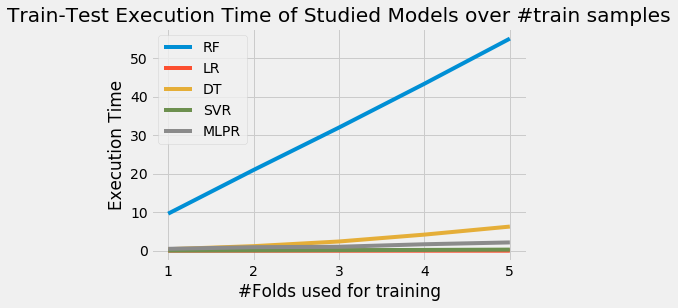

In [60]:
# Comparing Models
import pandas
time_compare = pandas.DataFrame(columns=['RF','LR','DT','KNN', 'KNNR','SVR','MLPR'], index=[1,2,3,4,5])
time_compare.RF=rfbestmodel['time']
time_compare.LR=lsbestmodel['time']
time_compare.DT=dtbestmodel['time']
time_compare.KNN=knnbestmodel['time']
time_compare.KNNR=knnrbestmodel['time']
time_compare.SVR=svrbestmodel['time']
time_compare.MLPR=mlprbestmodel['time']
z
time_compare.drop(columns=['KNN','KNNR'], inplace=True)

ax = time_compare.plot(subplots=False, title='Train-Test Execution Time of Studied Models over #train samples',xticks=[1,2,3,4,5])
ax.set_xlabel("#Folds used for training")
ax.set_ylabel("Execution Time")